In [1]:
import numpy as np
import os
import six.moves.urllib as urllib
import sys
import tarfile
import tensorflow as tf
import zipfile

from distutils.version import StrictVersion
from collections import defaultdict
from io import StringIO
from matplotlib import pyplot as plt
from PIL import Image

# This is needed since the notebook is stored in the object_detection folder.
sys.path.append("..")
from object_detection.utils import ops as utils_ops

if StrictVersion(tf.__version__) < StrictVersion('1.9.0'):
  raise ImportError('Please upgrade your TensorFlow installation to v1.9.* or later!')

In [14]:
# This is needed to display the images.
%matplotlib inline

In [3]:
from utils import label_map_util
from utils import visualization_utils as vis_util

In [4]:
MODEL_NAME = 'ssd_mobilenet_v2_coco_2018_03_29'

MODEL_FILE = MODEL_NAME + '.tar.gz'
DOWNLOAD_BASE = 'http://download.tensorflow.org/models/object_detection/'

# Path to frozen detection graph. This is the actual model that is used for the object detection.
PATH_TO_FROZEN_GRAPH = MODEL_NAME + '/frozen_inference_graph.pb'

# List of the strings that is used to add correct label for each box.
PATH_TO_LABELS = os.path.join('../data', 'mscoco_label_map.pbtxt')

In [5]:
opener = urllib.request.URLopener()
opener.retrieve(DOWNLOAD_BASE + MODEL_FILE, MODEL_FILE)
tar_file = tarfile.open(MODEL_FILE)
for file in tar_file.getmembers():
  file_name = os.path.basename(file.name)
  if 'frozen_inference_graph.pb' in file_name:
    tar_file.extract(file, os.getcwd())

In [6]:
detection_graph = tf.Graph()
with detection_graph.as_default():
  od_graph_def = tf.GraphDef()
  with tf.gfile.GFile(PATH_TO_FROZEN_GRAPH, 'rb') as fid:
    serialized_graph = fid.read()
    od_graph_def.ParseFromString(serialized_graph)
    tf.import_graph_def(od_graph_def, name='')

In [7]:
category_index = label_map_util.create_category_index_from_labelmap(PATH_TO_LABELS, use_display_name=True)

In [8]:
def load_image_into_numpy_array(image):
  (im_width, im_height) = image.size
  return np.array(image.getdata()).reshape(
      (im_height, im_width, 3)).astype(np.uint8)

In [9]:
# For the sake of simplicity we will use only 2 images:
# image1.jpg
# image2.jpg
# If you want to test the code with your images, just add path to the images to the TEST_IMAGE_PATHS.
PATH_TO_TEST_IMAGES_DIR = '../test_images'
TEST_IMAGE_PATHS = [ os.path.join(PATH_TO_TEST_IMAGES_DIR, 'image{}.jpg'.format(i)) for i in range(1, 3) ]

# Size, in inches, of the output images.
IMAGE_SIZE = (12, 8)

In [10]:
sess=tf.Session(graph=detection_graph)

In [11]:
ops = detection_graph.get_operations()
all_tensor_names = {output.name for op in ops for output in op.outputs}
  #print(all_tensor_names)
tensor_dict = {}
for key in ['num_detections', 'detection_boxes', 'detection_scores',
            'detection_classes', 'detection_masks']:
    tensor_name = key + ':0'
    if tensor_name in all_tensor_names:
        tensor_dict[key] = detection_graph.get_tensor_by_name(tensor_name)

In [12]:
def run_inference_for_single_image(image, graph):
  # Get handles to input and output tensors
     
  image_tensor = graph.get_tensor_by_name('image_tensor:0')

  # Run inference
  output_dict = sess.run(tensor_dict,
                          feed_dict={image_tensor: np.expand_dims(image, 0)})

  # all outputs are float32 numpy arrays, so convert types as appropriate
  output_dict['num_detections'] = int(output_dict['num_detections'][0])
  output_dict['detection_classes'] = output_dict[
      'detection_classes'][0].astype(np.uint8)
  output_dict['detection_boxes'] = output_dict['detection_boxes'][0]
  output_dict['detection_scores'] = output_dict['detection_scores'][0]
  if 'detection_masks' in output_dict:
    output_dict['detection_masks'] = output_dict['detection_masks'][0]
  return output_dict

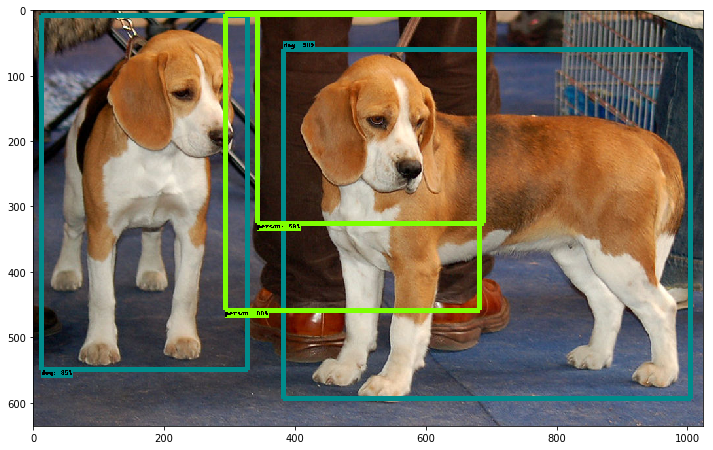

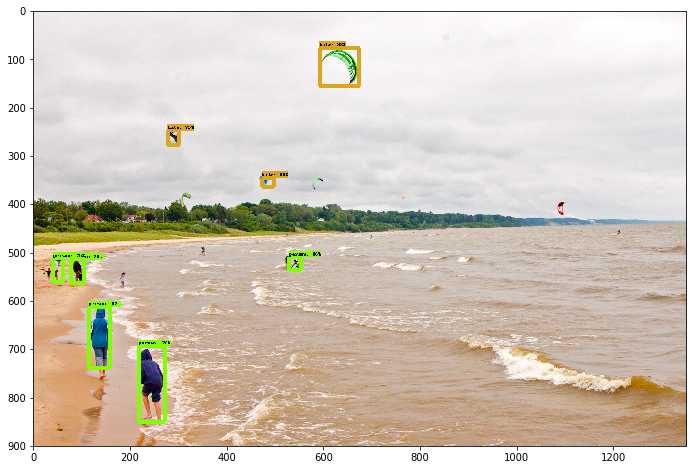

In [19]:
for image_path in TEST_IMAGE_PATHS:
  image = Image.open(image_path)
  # the array based representation of the image will be used later in order to prepare the
  # result image with boxes and labels on it.
  image_np = load_image_into_numpy_array(image)
  # Expand dimensions since the model expects images to have shape: [1, None, None, 3]
  image_np_expanded = np.expand_dims(image_np, axis=0)
  # Actual detection.
  output_dict = run_inference_for_single_image(image_np, detection_graph)
  # Visualization of the results of a detection.
  vis_util.visualize_boxes_and_labels_on_image_array(
      image_np,
      output_dict['detection_boxes'],
      output_dict['detection_classes'],
      output_dict['detection_scores'],
      category_index,
      instance_masks=output_dict.get('detection_masks'),
      use_normalized_coordinates=True,
      line_thickness=8)
  plt.figure(figsize=IMAGE_SIZE)
  plt.imshow(image_np)